<a href="https://colab.research.google.com/github/MoriyaBitton/Machine_learning/blob/main/Final_Project_Machin_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<u>Final Project - Machin Learning</u>**

---



---



> **Moriya Bitton** &emsp; **ID: 316451749** 
<br>**Hay Hoffman** &emsp; **ID: 203265186**

## **<u>Introduction</u>**

Machine learning (ML) algorithms are a group of algorithms with a common feature of linearity, which perform regression and classification tasks, usually for high-dimensional data, by finding the rule they represent. 
<br>In this algorithm, a line or hyperplane is used to separate the data into different labels (for classification) or to construct an equation that predicts the future values of a given point in the data (for regression), based on other points' values. Unlike high-dimensional data, images have a grid structure and are defined by their connections between pixels, which makes conventional ML algorithms unsuitable for image labeling. 

Deep neural networks (DNN) are nonlinear algorithms that use convolution neural networks (CNN) to overcome ML's obstacles. In CNN's, pixels within an image are learned spatially by multiplying learnable matrices along the image called kernels, reducing their size, and activating nonlinear functions. 
<br>The extraction of features from data is an important step in any learning process, whether it is deep learning (DL) or machine learning (ML). 
<br>In most algorithms, it is part of their operation, but for others, it is their primary function. Autoencoders and principal component analysis (PCA) are two examples of these algorithms.
<br>By reducing the dataset dimension, PCA improves interpretability and minimizes information loss. An eigenvalue/eigenvector problem is solved by PCA, resulting in the creation of new variables that maximize dataset variance.
<br>An autoencoder reduces the dimensionality of data by focusing on relevant areas. In this process, input data is compressed, encoded, and then reconstructed as an output to reduce noise. In an autoencoder, incoming data is systematically reduced in complexity by multiple layers inside a neural network, resulting in a dramatically compressed version of the original. The decoding stage reconstructs the encoded data, with the output representing the input equivalently.  

---



---

## **<u>Project's objectives:</u>**

We aim to answer two questions:

1. Are traditional machine learning algorithms capable of classifying images despite their limitations?

2. How do feature extraction algorithms perform better as preprocessors?

<br>In our first experiment, we will only reshape and normalize images. <br>Next, we will feed the extracted data into the algorithm to compress it. 

<br>To test our research question, we will use the most common machine learning algorithms and compare their results with a simple deep learning network.
<br>We will train and test using the handwritten Mnisnt digits, which contain black and white 28x28 images with more than 70,000 images.
<br>Our DL models are built using TensorFlow and open-source libraries like sklearn.

---



---



#### **Impotrs**


In [1]:
# Basic 
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Dataset 
from keras.datasets import mnist

# Model 
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from keras.utils import np_utils
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Model

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop

from sklearn import metrics
from sklearn.metrics import accuracy_score

#### **MNIST - DataSet**

[Wikipedia page](https://en.wikipedia.org/wiki/MNIST_database)


In [2]:
# loading

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


<u>Data reshaping and normalization</u>




In [3]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

In [4]:
# shape of dataset

print('X_train: ' + str(x_train.shape), '\tY_train: ' + str(y_train.shape))
print('X_test:  ' + str(x_test.shape), '\tY_test:  ' + str(y_test.shape))

X_train: (60000, 784) 	Y_train: (60000,)
X_test:  (10000, 784) 	Y_test:  (10000,)


In [5]:
def plotting(history):
    colors = {'loss':'r', 'accuracy':'b', 'val_loss':'m', 'val_accuracy':'g'}
    plt.figure(figsize=(10,6))
    plt.xlabel("Epoch")

    for measure in history.keys():
        color = colors[measure]
        ln = len(history[measure])
        plt.plot(range(1,ln+1), history[measure], color + '-', label=measure)  # use last 2 values to draw line

    plt.legend(loc='upper left', scatterpoints = 1, frameon=False)

## **<u>Experiment 1: DL model vs. classic ML model without data preprocessing </u>**
*   Logistic Regression <br>
    In statistical analysis, logistic regression predicts whether a data set    belongs to a predefined class based on prior observations.
    By using the sigmoid function, logistic regression can set model output from 0 to 1, and the logistic loss is applied to penalize data classification errors.


*   SVM <br>
    The Support Vector Machine finds the hyperplane that labels the dataset using a linear model.
    Based on the constant margin from both sides of the hyperplane, the algorithm reduces the plane weights to find the closest point, creating the support vectors.
    Rather than learning the data itself, SVM learns the rules that the data represent instead of the data itself.

*   KNN <br>
    A k-nearest neighbor algorithm solves classification and regression problems by assuming that similar things exist nearby.
    Using a distance function, the algorithm classifies a new sample with the label of the k nearest neighbors whose distance is the smallest from the dataset.

*   Neural networks<br>
    We present a simple, fully-connected neural network constructed from a densely-connected NN layer with a relu activation function, followed by a dropout layer and a softmax layer at the output. We use the cross-entropy loss, which is the most common loss for classification problems, with adam  as an optimizer. We train the model with 128 batch sizes and 100 epochs.

---

In [6]:
y_train = keras.utils.np_utils.to_categorical(y_train, 10)
y_test = keras.utils.np_utils.to_categorical(y_test, 10)

#### **Neural Network Implementation**


In [7]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


#### **Models Comparison**

In [ ]:
# DNN - training and evaluation
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

# Logistic reggression - Training and evaluation 
clf_lr_org = LogisticRegression()
clf_lr_org.fit(x_train, np.argmax(y_train, axis=1))
acc_lr_org = clf_lr_org.score(x_test, np.argmax(y_test, axis=1))

# SVM - Training and evaluation 
clf_svm_org = LinearSVC()
clf_svm_org.fit(x_train, np.argmax(y_train, axis=1))
pred_svm_org = clf_svm_org.predict(x_test)
acc_svm_org = accuracy_score(np.argmax(y_test, axis=1), pred_svm_org)

# KNN - Training and evaluation 
clf_knn_org = KNeighborsClassifier()
clf_knn_org.fit(x_train, np.argmax(y_train, axis=1))
pred_knn_org = clf_knn_org.predict(x_test)
acc_knn_org = accuracy_score(np.argmax(y_test, axis=1), pred_knn_org)

#### **Results**

In [9]:
print("Test results:\n")
print("Deep neural network accuracy:\t{:.2f}%\n".format(score[1]*100))
print("Logisticl regression accuracy:\t{:.2f}%\n".format(acc_lr_org*100))
print("SVM accuracy:\t{:.2f}%\n".format(acc_svm_org*100))
print("KNN accuracy:\t{:.2f}%\n".format(acc_knn_org*100))

Test results:

Deep neural network accuracy:	98.24%

Logisticl regression accuracy:	92.56%

SVM accuracy:	91.80%

KNN accuracy:	96.88%



#### **Conclusions and Observations** 
We see from the results that DNN performs better than classic ML algorithms. We conjectured that the ML algorithms would not be able to accomplish the task of classifying images correctly, but the results show that we were wrong. This result raises another question, for what complexity level of images, such as classifying RGB images, or more extensive datasets such as ImageNet that contains 1000 classes, classic ML algorithms will provide suitable solutions, as observed here. Maybe a better research question should have been: "what is the complexity threshold that ML algorithms still manage to result well
?". Mabey, the answer to this question will open a window for a better understanding of the relation between DL algorithms and ML Algorithms for image classification. 

## **<u>Experiment 2: DL model vs. classic ML model with data preprocessing </u>**

#### **Autoencoder Model**
As for the encoder, we present a simple, fully-connected neural network constructed from a densely-connected NN layer with a relu activation function and a softmax layer at the output. We use the cross-entropy loss as well, with adam as an optimizer. We train the model with 128 batch sizes and 100 epochs. 

In [10]:
encoding_dim = 32  

input_img = tf.keras.Input(shape=(784,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = tf.keras.Model(input_img, decoded)

# Encoder
encoder = tf.keras.Model(input_img, encoded)

# Decoder
encoded_input = tf.keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.Model(encoded_input, decoder_layer(encoded_input))

# Autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
history = autoencoder.fit(x_train, x_train,
                          epochs=20,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test, x_test))

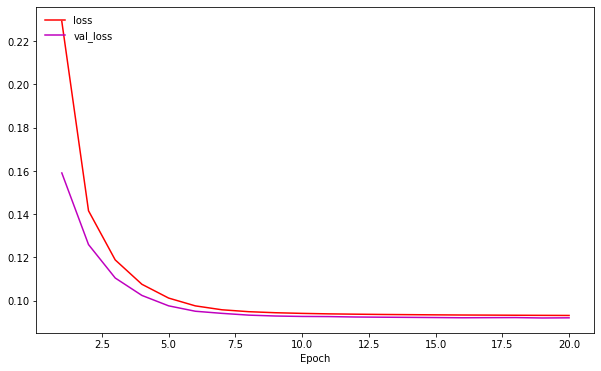

In [12]:
plotting(history.history)

In [13]:
encoded_imgs_train = encoder.predict(x_train)
encoded_imgs_test = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs_test)

#### **PCA - Principal Component Analysis**

In [14]:
pca = PCA(32)
pca.fit(x_train)
pca_train = pca.transform(x_train)
pca_test = pca.transform(x_test)
approximation = pca.inverse_transform(pca_test)

### **<u>PCA vs. Autoencoder Output</u>**


Original Data:


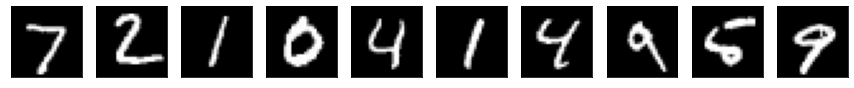


Encoded Data:


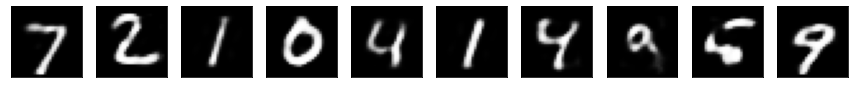


PCA Data:


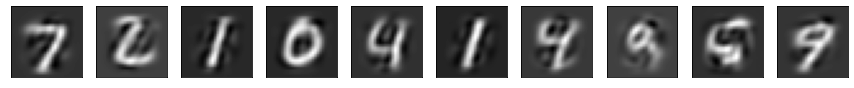

In [15]:
n = 10  

print("\nOriginal Data:")
plt.figure(figsize=(15, 5))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("\nEncoded Data:")
plt.figure(figsize=(15, 5))
for i in range(n):    
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("\nPCA Data:")
plt.figure(figsize=(15, 5))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(approximation[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### **Neural Network - Encoded Data**
We perform an adaptation for the previously proposed neural network to be compatible with autoencoder output

In [16]:
encoded_imgs_train_normalized = encoded_imgs_train / np.max(encoded_imgs_train)
print(encoded_imgs_train_normalized[0].shape)
encoded_imgs_test_normalized = encoded_imgs_test / np.max(encoded_imgs_test)

encoded_model = Sequential()
encoded_model.add(Dense(512, activation='relu', input_shape=(encoding_dim,)))
encoded_model.add(Dropout(0.2))
encoded_model.add(Dense(512, activation='relu'))
encoded_model.add(Dropout(0.2))
encoded_model.add(Dense(10, activation='softmax'))

encoded_model.summary()

encoded_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

(32,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               16896     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                5130      
                                                                 
Total params: 284,682
Trainable params: 284,682
Non-trainable params: 0
_________________________________________________________________


#### **Neural Network - PCA Data**

In [17]:
pca_model = Sequential()
pca_model.add(Dense(512, activation='relu', input_shape=(32,)))
pca_model.add(Dropout(0.2))
pca_model.add(Dense(512, activation='relu'))
pca_model.add(Dropout(0.2))
pca_model.add(Dense(10, activation='softmax'))

pca_model.summary()

pca_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               16896     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 10)                5130      
                                                                 
Total params: 284,682
Trainable params: 284,682
Non-trainable params: 0
_________________________________________________________________


#### **Learning Models Comparison**

In [ ]:
# DNN - training and evaluation

# ENCODED DATA
encoded_history = encoded_model.fit(encoded_imgs_train_normalized, y_train,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(encoded_imgs_test_normalized, y_test))

encoded_score = encoded_model.evaluate(encoded_imgs_test_normalized, y_test, verbose=0)

# PCA DATA
PCA_history = pca_model.fit(pca_train, y_train,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(pca_test, y_test))
pca_score = pca_model.evaluate(pca_test, y_test, verbose=0)


# Logistic reggression - Training and evaluation 

# ENCODED DATA
clf_lr_enc = LogisticRegression()
clf_lr_enc.fit(encoded_imgs_train_normalized, np.argmax(y_train, axis=1))
acc_lr_enc = clf_lr_enc.score(encoded_imgs_test_normalized, np.argmax(y_test, axis=1))

# PCA DATA
clf_lr_pca = LogisticRegression()
clf_lr_pca.fit(pca_train, np.argmax(y_train, axis=1))
acc_lr_pca = clf_lr_pca.score(pca_test, np.argmax(y_test, axis=1))


# SVM - Training and evaluation 

# ENCODED DATA
clf_svm_enc = LinearSVC()
clf_svm_enc.fit(encoded_imgs_train_normalized, np.argmax(y_train, axis=1))
pred_svm_enc = clf_svm_enc.predict(encoded_imgs_test_normalized)
acc_svm_enc = accuracy_score(np.argmax(y_test, axis=1), pred_svm_enc)

# PCA DATA
clf_svm_pca = LinearSVC()
clf_svm_pca.fit(pca_train, np.argmax(y_train, axis=1))
pred_svm_pca = clf_svm_pca.predict(pca_test)
acc_svm_pca = accuracy_score(np.argmax(y_test, axis=1), pred_svm_pca)


# KNN - Training and evaluation 

# ENCODED DATA
clf_knn_enc = KNeighborsClassifier()
clf_knn_enc.fit(encoded_imgs_train_normalized, np.argmax(y_train, axis=1))
pred_knn_enc = clf_knn_enc.predict(encoded_imgs_test_normalized)
acc_knn_enc = accuracy_score(np.argmax(y_test, axis=1), pred_knn_enc)

# PCA DATA
clf_knn_pca = KNeighborsClassifier()
clf_knn_pca.fit(pca_train, np.argmax(y_train, axis=1))
pred_knn_pca = clf_knn_pca.predict(pca_test)
acc_knn_pca = accuracy_score(np.argmax(y_test, axis=1), pred_knn_pca)

#### **Results**

In [25]:
print("\nTest Results\n")
print(100*'-')

print("\nDeep Neural Network Accuracy\n",
      "\nEncoded Data:\t{:.2f}%\n".format(encoded_score[1]*100),
      "\nPCA Data:\t{:.2f}%\n".format(pca_score[1]*100))
print(100*'-')

print("\nLogisticl Regression Accuracy\n",
      "\nEncoded Data:\t{:.2f}%\n".format(acc_lr_enc*100),
      "\nPCA Data:\t{:.2f}%\n".format(acc_lr_pca*100))
print(100*'-')

print("\nSVM Accuracy\n",
      "\nEncoded Data:\t{:.2f}%\n".format(acc_svm_enc*100),
      "\nPCA Data:\t{:.2f}%\n".format(acc_svm_pca*100))
print(100*'-')

print("\nKNN Accuracy\n",
      "\nEncoded Data:\t{:.2f}%\n".format(acc_knn_enc*100),
      "\nPCA Data:\t{:.2f}%\n".format(acc_knn_pca*100))


Test Results

----------------------------------------------------------------------------------------------------

Deep Neural Network Accuracy
 
Encoded Data:	98.01%
 
PCA Data:	98.45%

----------------------------------------------------------------------------------------------------

Logisticl Regression Accuracy
 
Encoded Data:	89.87%
 
PCA Data:	90.07%

----------------------------------------------------------------------------------------------------

SVM Accuracy
 
Encoded Data:	88.82%
 
PCA Data:	88.70%

----------------------------------------------------------------------------------------------------

KNN Accuracy
 
Encoded Data:	96.48%
 
PCA Data:	97.56%



#### **Conclusions and Observations** 
In this study, DNN performed better than classic ML algorithms once again. 

The feature extraction, in contrast to intuition, reduced the algorithm's performance, particularly the ML algorithms, which is curious and requires follow-up research that can focus on changing the PCA number of variables and using different autoencoder architectures. 

All algorithms performed better on the PCA's reduced data than on the autoencoder data; this may be because the PCA was limited to only 32 variables that captured the essence of the data, as demonstrated in the comparison part. Another explanation for the results could be that the autoencoder produces more features than the PCA, which leads to either a) overfitting or b) error during training. 

Results indicate that the accuracy of different algorithms is about 1%, which doesn't necessarily mean that one is better than another. 

Future studies could compare the accuracy and PCA number components, as well as different autoencoder architectures.